In [1]:
from constants import *
from functions import *
import numpy as np
from scipy.integrate import solve_ivp
import math
from units import *
from scipy.optimize import root_scalar
from numba import njit
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator

In [2]:
plt.rcParams['font.size']=22
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.minor.size']=5
plt.rcParams['xtick.major.width']=2
plt.rcParams['xtick.minor.width']=1
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.major.size']=10
plt.rcParams['ytick.minor.size']=5
plt.rcParams['ytick.major.width']=2
plt.rcParams['ytick.minor.width']=1
plt.rcParams['ytick.direction']='in'

In [5]:
X = 0.75
mu = 0.61

Mhalo = 1.e12* Msun
Ms_Mh = 0.02 #stellar mass to halo mass
lambda_cool = 0.6e-22

In [6]:
#Vc interpolator
r_grid = np.logspace(np.log10(0.001*kpc), np.log10(25*Rvir(Mhalo)), 1000)
Rvir_ = Rvir(Mhalo)
m = -0.1
vc_grid = 140. * (r_grid/(100*kpc)) **m * kmps
vc_interp = interp1d(r_grid,vc_grid)

In [7]:
lnvc_grid = np.log(vc_grid)
lnr_grid  = np.log(r_grid)

dlnvc_dlnr_grid = np.gradient(lnvc_grid, lnr_grid)
dlnvc_dlnr_grid_interp =  interp1d(r_grid,dlnvc_dlnr_grid)


In [8]:
def find_init_at_Rsonic(rsonic,T):
    cs = np.sqrt(gamma * kb * T/mu/mp)
    v  = cs
    vc = vc_interp(rsonic)
    tflow = rsonic/v
    
    # alpha = mu * (gamma-1) * lambda_cool * tflow/gamma/kb/T
    alpha =  kb * T/mu/lambda_cool/(gamma-1)/X
    nH = (2. - (vc/v)**2 ) * gamma * alpha/tflow
    rho = nH * mp/X
    Mdot = 4. * math.pi * rho*rsonic**2 * v

    return v, rho, Mdot

In [9]:
def soln_at_esp(v_rsonic, T_rsonic, rho_rsonic, rsonic, eps):

    dlnvc_dlnr_at_Rsonic = dlnvc_dlnr_grid_interp(rsonic)
    
    vc_rsonic  = vc_interp(rsonic)
    
    cs_rsonic  = v_rsonic
    x = (vc_rsonic/cs_rsonic)**2/2.
    a = 1.0
    
    lnrho = np.log(rho_rsonic)
    lnT = np.log(T_rsonic)
                 
    # constant1 = interp_dlnLambda_dlnT((lnrho, lnT)) + 1.5 *  interp_dlnLambda_dlnrho((lnrho, lnT))
    constant1 = 0.0
    b = 29.0* x/6 - 17.0/6.0 + ((1.-x)/3.) * constant1
    
    # constant2 = interp_dlnLambda_dlnrho((lnrho, lnT))
    constant2 = 0.0
    c = ((2./3.) * x * dlnvc_dlnr_at_Rsonic) +  (5*x*x) - (13.*x/3.0) + (2./3.)  - (5.*(1-x)**2/3.)*constant2
    
    if ((b*b - 4*a*c)<0):
        print('No transsonic soln!')
        return None, None, None, None
    else:
        sol1 = (-b - np.sqrt(b*b - 4*a*c))/(2.*a*c)
        sol2 = (-b + np.sqrt(b*b - 4*a*c))/(2.*a*c)
        sol = np.asarray([sol1,sol2])
        dlnv_dlnr_at_Rsonic = -1.5* sol + 3 - 5*x
        dlnM_dlnr = dlnv_dlnr_at_Rsonic - 0.5 * sol
        
        if(dlnM_dlnr[0]<0.0):   
            dlnT_dlnr_at_Rsonic = sol1
        elif(dlnM_dlnr[1]<0.0):
            dlnT_dlnr_at_Rsonic = sol2
        
        dlnv_dlnr_at_Rsonic = -1.5* dlnT_dlnr_at_Rsonic + 3 - 5*x
        
        delT = 1. + dlnT_dlnr_at_Rsonic * eps
        delv = 1. + dlnv_dlnr_at_Rsonic * eps
        delrho = 1. - (dlnv_dlnr_at_Rsonic + 2.) * eps
        
        T_ini = delT * T_rsonic
        v_ini = delv * v_rsonic
        rho_ini = delrho * rho_rsonic
        r_ini = (1.0 + eps) * rsonic

        return r_ini, v_ini, T_ini, rho_ini
    

In [10]:
def find_init_at_Rsonic(rsonic,T):
    cs = np.sqrt(gamma * kb * T/mu/mp)
    v  = cs
    vc = vc_interp(rsonic)
    tflow = rsonic/v
    
    alpha =  kb * T/mu/lambda_cool/(gamma-1)/X
    nH = (2. - (vc/v)**2 ) * gamma * alpha/tflow
    rho = nH * mp/X
    Mdot = 4. * math.pi * rho*rsonic**2 * v
    tcool = (cs*cs*rho/gamma)/(nH*nH*(gamma-1)*lambda_cool)
    return v, rho, Mdot

In [11]:

def flow_equations_lnr(lnr, ini_val, Mdot):
    
    logT, logrho = ini_val
    T = np.exp(logT)
    rho = np.exp(logrho)
    r   = np.exp(lnr)
    
    v = Mdot/(4.*math.pi*r*r*rho)
    
    nH = X * rho/mp
    cs = np.sqrt(gamma * kb * T/(mu * mp))
    
    lambda_cool = 0.6e-22
    
    tcool = (kb*T/mu/X)/((gamma-1) * nH *  lambda_cool)
    
    Mach = 0.0 # np.abs(v)/cs
    tflow = r/np.abs(v)
    tratio =  tflow/tcool
    
    vc_over_cs = (vc_interp(r)/cs)**2

    dlnrho_dlnr =  (-tratio/gamma - vc_over_cs + 2*Mach**2)  / (1-Mach**2)
    dlnT_dlnr = tratio + dlnrho_dlnr*(gamma-1)

    return dlnT_dlnr, dlnrho_dlnr

In [12]:
def find_sol(v_rsonic, T_rsonic, rho_rsonic, Mdot, rsonic):
    
    eps = 1.e-5
    
    rmin  =  rsonic*(1.+eps)
    rmax  =  20.* Rvir(Mhalo)
    
    r_ini, v_ini, T_ini, rho_ini = soln_at_esp(v_rsonic, T_rsonic, rho_rsonic, rsonic, eps)
   
    #Solve equation in lnr
    ini_value = [T_ini, rho_ini]
    
    log_ini_value = np.log(ini_value)
    lnr_span = (np.log(r_ini), np.log(rmax))
    lnr_eval = np.linspace(lnr_span[0], lnr_span[1], 2000)
    
    sol = solve_ivp(flow_equations_lnr, lnr_span, log_ini_value, t_eval=lnr_eval, method='RK45',args=(Mdot,),\
                    max_step=0.1, atol=1e-6,rtol=1e-6)
    
    lnT_sol, lnrho_sol = sol.y
    return lnT_sol, lnrho_sol, lnr_eval, Mdot

In [13]:
A = 0.9*(1-2*m)
B = (1. + 4*m/3.)
rsonic = 1. * kpc
vc = vc_interp(rsonic)
Mdot = Msun/yr_to_sec
nH = vc *  np.sqrt(9*B*Mdot/(40.*math.pi * A * rsonic**3 * lambda_cool))
rho_rsonic = nH * mp/X
v_rsonic = Mdot/(4.*math.pi * rsonic**2 * rho_rsonic)
T_rsonic =  (6./5./A) * (rsonic/Rvir_)**(2*m) * T_vir(Mhalo) 
# print('vrsonic=', v_rsonic/kmps, 'rho_rsoni=', rho_rsonic/mp, 'Mdot=', Mdot*yr_to_sec/Msun, 'T_rsonic=', T_rsonic/1.e6, 'vc=', vc/kmps)
solution = find_sol(v_rsonic, T_rsonic, rho_rsonic, Mdot, rsonic)

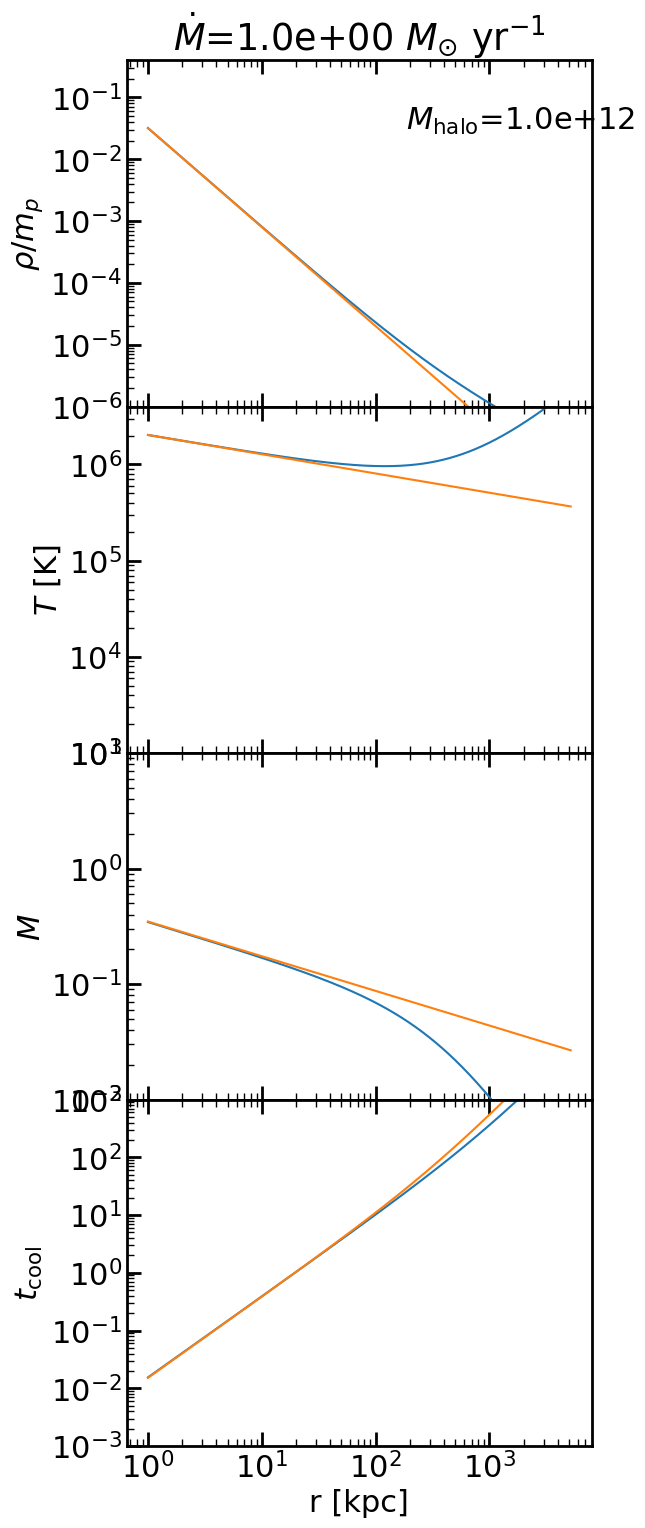

In [14]:
T = np.exp(solution[0])
rho = np.exp(solution[1])
lnr = (solution[2])
Mdot = solution[3]
cs = np.sqrt(gamma * kb * T/(0.6 * mp))
rkpc = np.exp(lnr)/kpc

r = rkpc*kpc
v = Mdot/(4*math.pi*r*r*rho)
Mach = v/cs
tflow = np.exp(lnr)/v
tff = np.sqrt(2) * r/v

tcool = np.zeros(rkpc.shape[0])
for i in range(tcool.shape[0]):
    P = kb * rho[i] * T[i]/0.6/mp
    nH = X * rho[i]/mp
    log10nH = np.log10(nH)
    log10T  = np.log10(T[i])
    cloudy = 0.6e-22
    tcool[i] = P/(nH*nH*cloudy*(gamma-1))

tratio = tcool/tflow

vc = v_c(Rvir_, Mhalo, Ms_Mh) * (r/Rvir_)**m
m=-0.1
vc = 140. * (rkpc/(100)) **m * kmps
A = 0.9 * (1.-2*m)
B = 1. + 4*m/3.
Tvir = T_vir(Mhalo)
Rvir_ = Rvir(Mhalo)
lambda_cool = 0.6e-22
Mach_anl = (X*A/mp/vc**2) * np.sqrt(5 * Mdot * lambda_cool/(18.*math.pi*B*r))
nH_anl   = vc *  np.sqrt(9*B*Mdot/(40.*math.pi * A * r**3 * lambda_cool))
rho_anl = nH_anl * mp/X
v_anl = Mdot/(4.*math.pi * rsonic**2 * rho_rsonic)
tflow_anl = r/v_rsonic
T_anl =  (6./5./A) * (r/Rvir_)**(2*m) * T_vir(Mhalo) 
tcool_anl = tflow/B

fig, ax = plt.subplots(4, 1, gridspec_kw = {'wspace':0.1, 'hspace':0.0},figsize=(6, 18))

ylabel = [r'$\rho/m_p$', r'$T$ [K]', r'$M$', r'$t_{\rm cool}$']

ax[0].plot(rkpc, rho*X/mp)
ax[0].plot(rkpc, nH_anl)
ax[1].plot(rkpc, T)
ax[1].plot(rkpc, T_anl)
ax[2].plot(rkpc, Mach)
ax[2].plot(rkpc, Mach_anl)
ax[3].plot(rkpc, tcool/yr_to_sec/1.e9)
ax[3].plot(rkpc, tcool_anl/yr_to_sec/1.e9)


ax[-1].set_xlabel('r [kpc]')
for i in range(4):
    ax[i].set_ylabel(ylabel[i])
plt.setp(ax, 'xscale', ('log'))
plt.setp(ax, 'yscale', ('log'))
# plt.setp(ax, 'xlim', (0.5,2.e3))
ax[0].set_ylim(1.e-6, 4.e-1)
ax[1].set_ylim(1.e3, 4.e6)
ax[2].set_ylim(1.e-2,1.e1)
ax[3].set_ylim(1.e-3,1.e3)

ax[0].tick_params(axis='x', which='both', labelbottom=False, top=True, bottom=True)
ax[1].tick_params(axis='x', which='both', labelbottom=False, top=True, bottom=True)
ax[-2].tick_params(axis='x', which='both', top=True, bottom=True, labelbottom=False)
ax[-1].tick_params(axis='x', which='both', top=True, bottom=True, labelbottom=True)
ax[0].set_title(r'$\dot{M}$=%.1e'%(Mdot*yr_to_sec/Msun) + r' $M_{\odot} \ \rm{yr}^{-1}$')
ax[0].text(0.6, 0.8, r'$M_{\rm halo}$=%.1e'%(Mhalo/Msun), transform=ax[0].transAxes)
# ax[0].text(0.6, 0.7, r'$M_{\rm gas}$=%.1e'%(tot_gas_mass/Msun), transform=ax[0].transAxes)
# ax[0].text(0.6, 0.7, r'$\rho_{\rm ini}$=%.1e'%(rho0/mp), transform=ax[0].transAxes)
# ax[0].text(0.6, 0.6, r'$T_{\rm ini}$=%.1e'%(T), transform=ax[0].transAxes)

image_name = 'Figures/solution_' + str(Mdot*yr_to_sec/Msun) +'.jpeg'
# plt.savefig(image_name, bbox_inches='tight')